### Import the packages

In [66]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats

from sklearn.model_selection import train_test_split, KFold, cross_validate

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR 
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge,Lasso

### Create UDFs

In [2]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.sum(), x.mean(), x.median(), x.min(), x.quantile(0.01), x.quantile(0.05),
                      x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), x.quantile(0.90),x.quantile(0.95), 
                      x.quantile(0.99),x.max(),x.skew(),x.kurt(), x.std(), x.var(), (x==0).sum(), (x==0).sum()*100/len(x),
                      x.isnull().sum(),x.isnull().sum()*100/len(x) ], 
                  index = ['N', 'SUM', 'MEAN','MEDIAN', 'MIN', 'P1', 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,
                          'P95' ,'P99' ,'MAX','SKEW' ,'KURT' ,'STD', 'VAR', 'ZEROS' ,'%ZEROS', 'NMISS', '%NMISS'])


In [3]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), x.nunique(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'NUNIQUE', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# To get a reduced heatmap with columns that only have a correlation above the given threshold
def trimmed_corr(df, thresh):
    df_corr=df.corr().abs()
    for col in df_corr.columns:
        df_corr[col][col]=0
    high_corr=df_corr.max()[df_corr.max()>thresh].index
    print('\n**************** FEATURES OF INTEREST ****************\n')
    print(high_corr)
    print('\n******************************************************\n')
    plt.figure(figsize=(15,15), dpi=150)
    sns.heatmap(df[high_corr].corr(), annot=True, cmap="YlGnBu", fmt=".2f")
    plt.show()
    sns.pairplot(df[high_corr], diag_kind="kde")

In [5]:
# To get groups of features with high correlation among each other
def corr_groups(df, thresh):
    related_features = []
    cols = list(df.columns)
    corr_scores = {}
    for f in cols:
        corr_scores[f]=0
    for i in range(len(cols)-1):
        rel_features=[cols[i]]
        for j in range(i+1, len(cols)):
            score = df[cols[i]].corr(df[cols[j]])
            if((abs(score) > thresh) & (abs(score) > corr_scores[cols[j]])):
                rel_features.append(cols[j])
                corr_scores[cols[j]] = abs(score)
        if (len(rel_features) > 1):
            related_features.append(rel_features)
    print('\n**************** GROUPS WITH HIGH CORRELATION ****************\n')
    for i in range(len(related_features)):
        print("------------- Group {} -------------".format(i+1))
        print(related_features[i],'\n')
        plt.figure(dpi=150)
        sns.heatmap(df[related_features[i]].corr(), annot=True, cmap="YlGnBu", fmt=".2f")
        plt.show()

In [6]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [7]:
# A utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Import Data

In [8]:
data = pd.read_excel('Data Set.xlsx') 

In [9]:
# Creating Dependent Y column
data['Total_Spend']=data['cardspent']+data['card2spent']
data.drop(['cardspent','card2spent','custid'],inplace=True,axis=1)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 128 entries, region to Total_Spend
dtypes: float64(30), int64(97), object(1)
memory usage: 4.9+ MB


### A brief assesment of missing data

In [11]:
mask = data.isnull()
total = mask.sum()
percent = 100*mask.mean()

missing_data = pd.concat([total, percent], axis=1,join='outer',
                         keys=['count_missing', 'perc_missing'])
missing_data.sort_values(by='perc_missing', ascending=False, inplace=True)

missing_data[missing_data.count_missing > 0]

,count_missing,perc_missing
lnwiremon,3656,73.12
lnwireten,3656,73.12
lnequipten,3296,65.92
lnequipmon,3296,65.92
lntollten,2622,52.44
lntollmon,2622,52.44
lncardten,1422,28.44
lncardmon,1419,28.38
longten,3,0.06
lnlongten,3,0.06


##### The bottom few features in the above table have less than 1% data missing and can be imputed using the column median value, townsize however will later be converted to categorical

In [12]:
from sklearn.impute import SimpleImputer

x = missing_data[(missing_data.perc_missing < 1) & (missing_data.perc_missing > 0)].index
imputer = SimpleImputer(strategy='median')
data[x] = imputer.fit_transform(data[x])

### Time to set apart the categorical and continuous features 

In [13]:
cat = '''
region
townsize
gender
agecat
birthmonth
edcat
jobcat
union
employ
empcat
retire
inccat
default
jobsat
marital
spousedcat
homeown
hometype
address
addresscat
cars
carown
cartype
carcatvalue
carbought
carbuy
commute
commutecat
commutecar
commutemotorcycle
commutecarpool
commutebus
commuterail
commutepublic
commutebike
commutewalk
commutenonmotor
telecommute
reason
polview
polparty
polcontrib
vote
card
cardtype
cardbenefit
cardfee
cardtenure
cardtenurecat
card2
card2type
card2benefit
card2fee
card2tenure
card2tenurecat
active
bfast
churn
tollfree
equip
callcard
wireless
multline
voice
pager
internet
callid
callwait
forward
confer
ebill
owntv
ownvcr
owndvd
owncd
ownpda
ownpc
ownipod
owngame
ownfax
news
response_01
response_02
response_03
'''
cat_features = cat.replace("\n", ",").split(',')[1:-1]
data[cat_features] = data[cat_features].astype("category")
data_conti = data.select_dtypes(exclude='category') 
data_cat = data.select_dtypes(include='category') 

### Handling Outliers
#### There are some extreame high or extream low value which need to rectify so that it will not have impact on our model

In [14]:
# Handling Outliers for numerical data - Through function
# Since some continuous features have a high volume of zeros, we need to apply a little trick for a more fair clipping

def outlier_capping(x):
    low=x[x!=0].quantile(0.01)
    high=x[x!=0].quantile(0.99)
    x.loc[x!=0] = x.loc[x!=0].clip(low, high)
    return x

data_conti = data_conti.apply(lambda x: outlier_capping(x))

In [15]:
data_cat.apply(categorical_var_summary).T.sort_values(by='NUNIQUE', ascending=False).head(15)

,N,NMISS,NUNIQUE,MODE,FREQ,PERCENT
address,5000.0,0.0,57.0,0.0,245.0,4.9
employ,5000.0,0.0,52.0,0.0,659.0,13.18
cardtenure,5000.0,0.0,41.0,3.0,246.0,4.92
card2tenure,5000.0,0.0,31.0,2.0,304.0,6.08
birthmonth,5000,0,12,September,458,9.16
commute,5000.0,0.0,10.0,1.0,2855.0,57.1
cars,5000.0,0.0,9.0,2.0,1607.0,32.14
polview,5000.0,0.0,7.0,4.0,1733.0,34.66
jobcat,5000.0,0.0,6.0,2.0,1640.0,32.8
spousedcat,5000.0,0.0,6.0,-1.0,2599.0,51.98


#### Few categorical features have very high cardinality

In [16]:
data_cat.apply(categorical_var_summary).T.sort_values(by='PERCENT', ascending=False).head(15)

,N,NMISS,NUNIQUE,MODE,FREQ,PERCENT
owntv,5000.0,0.0,2.0,1.0,4915.0,98.3
commutenonmotor,5000.0,0.0,2.0,0.0,4708.0,94.16
owncd,5000.0,0.0,2.0,1.0,4664.0,93.28
response_01,5000.0,0.0,2.0,0.0,4582.0,91.64
ownvcr,5000.0,0.0,2.0,1.0,4578.0,91.56
owndvd,5000.0,0.0,2.0,1.0,4568.0,91.36
commutepublic,5000.0,0.0,2.0,0.0,4523.0,90.46
commutemotorcycle,5000.0,0.0,2.0,0.0,4487.0,89.74
response_03,5000.0,0.0,2.0,0.0,4487.0,89.74
commutebike,5000.0,0.0,2.0,0.0,4383.0,87.66


#### The frequency of the mode is exceedingly high in some categorical features

### A few notes from a manual assesment of the Categorical features and their continuous counterparts
<ol style="color:green; font-size: 1.25em">
  <li>'age' has a categorical counterpart 'agecat'</li>
  <li>'ed' has a categorical counterpart 'edcat'</li>
  <li>'income' has a categorical counterpart 'inccat' and a log transform 'lninc'</li>
  <li>'creddebt' has a log transform 'lncreddebt'</li>
  <li>'othdebt' has a log transform 'lnothdebt'</li>
  <li>'spoused' has a categorical counterpart 'spousedcat'</li>
  <li>'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish' seem related</li>
  <li>'wireless' could be replaced with 'wiremon' or 'wireten'</li>
  <li>'birthmonth' seems logically insignificant</li>
  <li>'income' has a categorical counterpart 'inccat'</li>
  <li>'address' has a high cardinality, 'addresscat' would be a more reasonable predictor</li>
  <li>'employ', 'cardtenure', 'card2tenure' should be treated as continuous than categorical</li>
  <li>'carvalue' has a categorical counterpart 'carcatvalue' </li>
  <li>'commutecat' is more reasonable than 'commute' and 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute'</li>
  <li>'carditems' and 'card2items' shouldn't participate in the modelling</li>
  <li>'tollfree' can be replaced with 'tollmon' or 'tollten'</li>
  <li>'equip' could be replaced with 'equipmon' or 'equipten'</li>
  <li>'callcard' could be replaced with 'cardmon' or 'cardten'</li>
  <li>'wireless' could be replaced with 'wiremon' or 'wireten'</li>
  <li>'vote', 'bfast', 'voice', 'pager' seem logically insignificant</li>
  <li>'employ' has a categorical counterpart 'empcat'</li>
  <li>'cardtenure' has a categorical counterpart 'cardtenurecat'</li>
  <li>'card2tenure' has a categorical counterpart 'card2tenurecat'</li>
</ol>

### This information can be combined with the statistical inferences for feature seection at a later stage

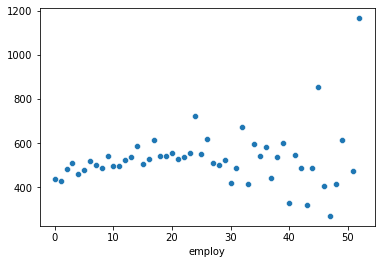

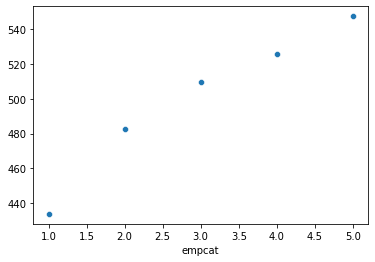

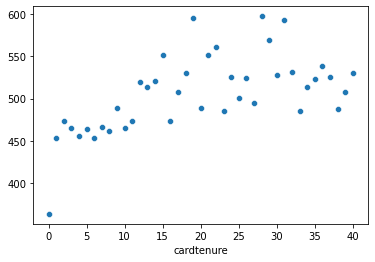

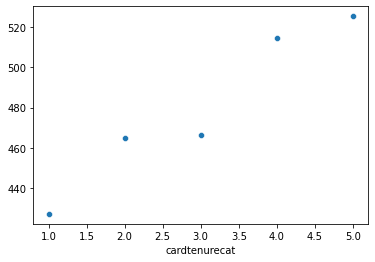

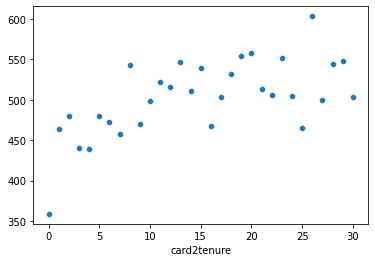

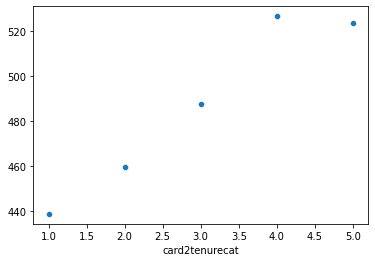

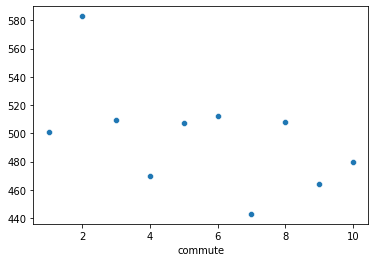

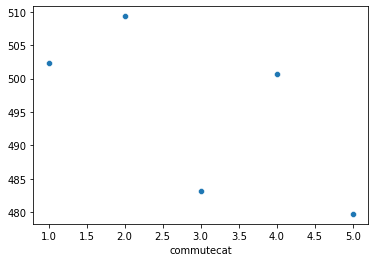

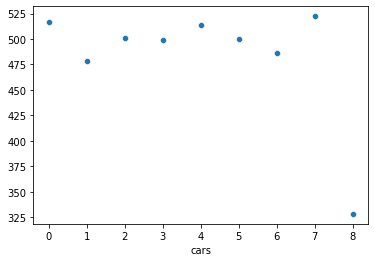

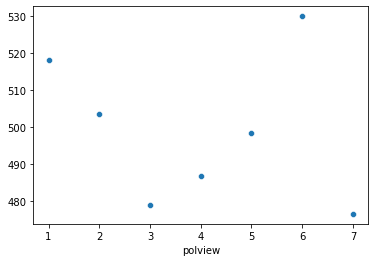

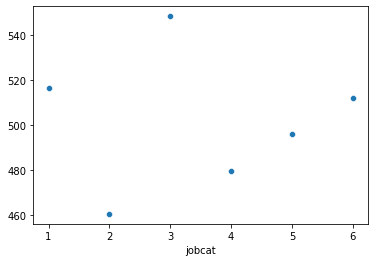

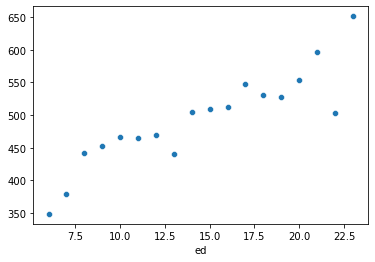

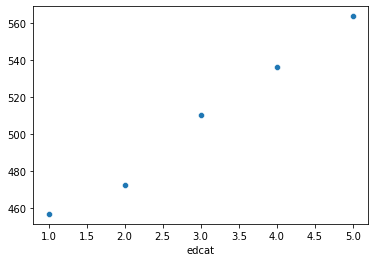

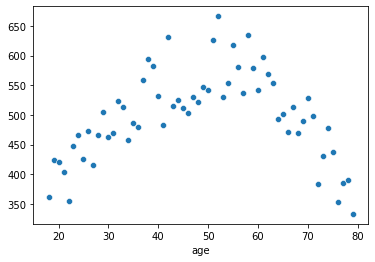

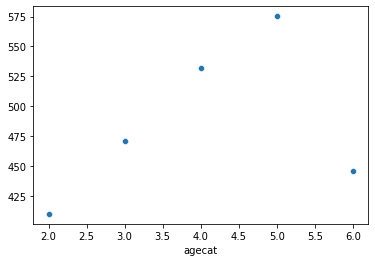

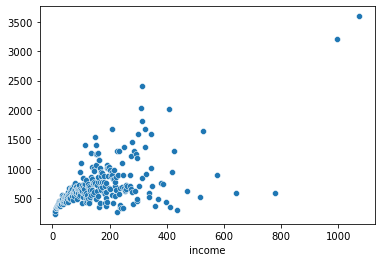

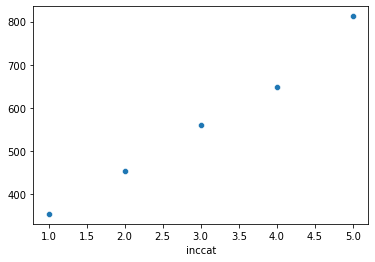

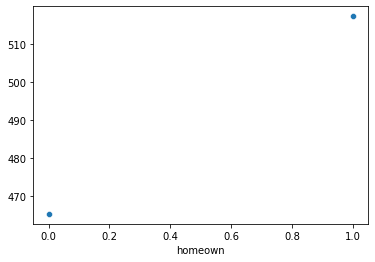

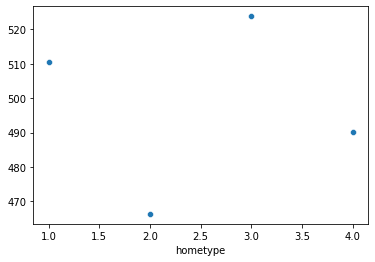

In [17]:
for i in ['employ', 'empcat', 'cardtenure', 'cardtenurecat', 'card2tenure', 'card2tenurecat', 'commute', 'commutecat',
         'cars', 'polview', 'jobcat', 'ed', 'edcat', 'age', 'agecat', 'income', 'inccat', 'homeown', 'hometype']:
    sctr = data.groupby(i)['Total_Spend'].mean()
    sns.scatterplot(x=sctr.index, y=sctr.values)
    plt.show();

#### Education is the only feature that seems to be following a linear relatioship with Total income

In [18]:
data.drop(columns=['address', 'birthmonth'], inplace=True)
data[['employ', 'cardtenure', 'card2tenure']]=data[['employ', 'cardtenure', 'card2tenure']].astype('int32')
data_conti = data.select_dtypes(exclude='category').copy()
data_cat = data.select_dtypes(include='category').copy()

### It's worth noticing that the features with a high volume of missing data with the 'ln' prefix are actually log transformation of the corresponding features (without the 'ln' prefix) where the Null values in the former correspond with Zeros in the later.

### That points us to a quick inspection of skewness and count of zeros in the continuous features

In [19]:
data_conti.apply(continuous_var_summary).round(3).T.sort_values(by=['NMISS'], ascending=False).head()

,N,SUM,MEAN,MEDIAN,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX,SKEW,KURT,STD,VAR,ZEROS,%ZEROS,NMISS,%NMISS
lnwireten,1344.0,9150.129,6.808,7.147,2.542,3.040,4.114,4.881,6.158,7.147,7.755,8.107,8.311,8.690,9.462,-1.055,0.705,1.284,1.649,0.0,0.0,3656.0,73.12
lnwiremon,1344.0,4845.121,3.605,3.598,2.542,2.807,2.993,3.119,3.330,3.598,3.865,4.103,4.267,4.577,5.227,0.294,0.185,0.390,0.152,0.0,0.0,3656.0,73.12
lnequipten,1704.0,11497.393,6.747,7.051,2.489,3.170,4.251,5.033,6.172,7.051,7.650,7.978,8.118,8.369,8.783,-1.107,0.813,1.199,1.438,0.0,0.0,3296.0,65.92
lnequipmon,1704.0,6134.805,3.600,3.599,2.833,2.968,3.140,3.235,3.413,3.599,3.790,3.971,4.065,4.269,4.666,0.099,-0.022,0.283,0.080,0.0,0.0,3296.0,65.92
lntollmon,2378.0,7712.400,3.243,3.229,2.079,2.346,2.584,2.741,2.970,3.229,3.519,3.790,3.927,4.191,4.623,0.121,-0.150,0.405,0.164,0.0,0.0,2622.0,52.44


### Eliminating some features based on the above insights, as the log transforms are only effective when the distribution is at least smooth if not normal, the high density of zeros makes the log transformation redundant

In [20]:
# To drop the features with a high volume of missing data
cols = data_conti.columns[data_conti.isnull().any()].tolist()
data_conti.drop(columns=cols, inplace=True)
data_conti.isnull().any().sum()

0

### To assess the distribution of the target Variable

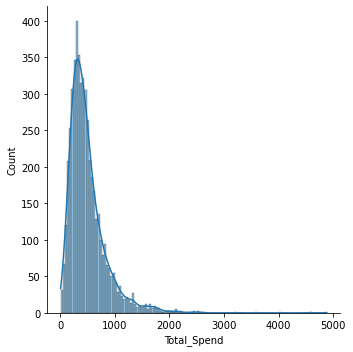

In [21]:
sns.displot(data_conti.Total_Spend, kde=True)
plt.show()

In [22]:
# The above curve is not normal. Toconvert it normal take a log,exp etc
data_conti['Total_Spend_log']=np.log(data_conti['Total_Spend']+1)


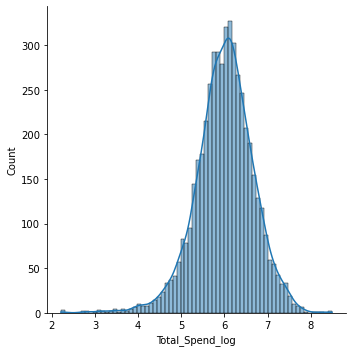

In [23]:
sns.displot(data_conti.Total_Spend_log, kde=True)
plt.show()

In [24]:
#data_conti.drop(columns=['Total_Spend'], inplace=True)

### An assessment of feature importance before proceeding with the model

In [25]:
from statsmodels.stats.anova import anova_lm
cat_pvals = []
for cat in data.select_dtypes(include='category').columns:
    model = smf.ols("Total_Spend ~ " + cat , data=data).fit()
    cat_pvals.append((cat,anova_lm(model).iloc[0,4]))
cat_anova = pd.DataFrame(cat_pvals, columns =['Feature', 'p_value']).sort_values(by='p_value', ascending=False)
cat_anova

,Feature,p_value
30,commutepublic,9.466001e-01
1,townsize,8.660964e-01
46,card2type,8.460783e-01
27,commutecarpool,7.693006e-01
32,commutewalk,7.064646e-01
25,commutecar,6.378427e-01
43,cardfee,6.020053e-01
17,cars,5.930200e-01
52,churn,5.805161e-01
6,union,5.706785e-01


In [26]:
cat = list(cat_anova[cat_anova.p_value<0.05].Feature.values)

# Categorical features that have a continuous counterpart
cat_conti = ['card2tenurecat', 'cardtenurecat', 'empcat', 'carcatvalue', 'spousedcat', 'inccat', 'edcat', 'agecat']
cat = [x for x in cat if x not in cat_conti]

data_cat=data_cat[cat]

In [27]:
data_cat.head()

,card2fee,region,callcard,voice,ownipod,commutebike,news,response_03,ownpc,equip,multline,callid,hometype,forward,pager,callwait,tollfree,ownfax,confer,jobsat,internet,wireless,owntv,vote,jobcat,ownpda,homeown,gender,addresscat,owncd,ownvcr,carown,owndvd,reason,card2,retire,card
0,0,1,1,1,1,0,0,0,0,1,1,0,2,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,1,0,1,1,1,9,5,0,3
1,0,5,1,1,1,1,1,0,1,1,1,1,3,1,1,0,0,1,0,1,4,1,1,0,2,1,1,0,1,1,1,1,1,9,4,0,2
2,0,3,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,4,0,0,1,0,2,0,1,1,5,1,1,1,1,2,4,0,2
3,0,4,1,0,1,0,1,0,1,0,1,0,3,0,0,0,0,0,0,2,2,0,1,0,2,0,1,0,2,1,1,1,1,9,3,0,2
4,0,2,1,1,0,0,0,0,1,0,0,1,2,1,0,1,1,0,1,1,3,1,1,0,2,0,0,0,2,1,1,0,1,9,1,0,4


### Dummy creation for categorical data

In [28]:
# since the features with two unique values already have the values 0 or 1

cat_dummy = data_cat.columns

for c_feature in cat_dummy:
    data_cat=create_dummies(data_cat,c_feature)

In [29]:
data_cat.head()

,card2fee_1,region_2,region_3,region_4,region_5,callcard_1,voice_1,ownipod_1,commutebike_1,news_1,response_03_1,ownpc_1,equip_1,multline_1,callid_1,hometype_2,hometype_3,hometype_4,forward_1,pager_1,callwait_1,tollfree_1,ownfax_1,confer_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,internet_1,internet_2,internet_3,internet_4,wireless_1,owntv_1,vote_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,ownpda_1,homeown_1,gender_1,addresscat_2,addresscat_3,addresscat_4,addresscat_5,owncd_1,ownvcr_1,carown_0,carown_1,owndvd_1,reason_2,reason_3,reason_4,reason_9,card2_2,card2_3,card2_4,card2_5,retire_1,card_2,card_3,card_4,card_5
0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0
1,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0
2,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0
3,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0
4,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0


### Merge Numerical and categorical data

In [30]:
data_new = pd.concat([data_conti, data_cat], axis=1)

In [31]:
data_new.head()

,age,ed,employ,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,card2tenure,tenure,longmon,lnlongmon,longten,lnlongten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,Total_Spend,Total_Spend_log,card2fee_1,region_2,region_3,region_4,region_5,callcard_1,voice_1,ownipod_1,commutebike_1,news_1,response_03_1,ownpc_1,equip_1,multline_1,callid_1,hometype_2,hometype_3,hometype_4,forward_1,pager_1,callwait_1,tollfree_1,ownfax_1,confer_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,internet_1,internet_2,internet_3,internet_4,wireless_1,owntv_1,vote_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,ownpda_1,homeown_1,gender_1,addresscat_2,addresscat_3,addresscat_4,addresscat_5,owncd_1,ownvcr_1,carown_0,carown_1,owndvd_1,reason_2,reason_3,reason_4,reason_9,card2_2,card2_3,card2_4,card2_5,retire_1,card_2,card_3,card_4,card_5
0,20,15,0,31,3.433987,11.1,1.200909,0.183079,2.240091,0.806516,-1,3,0,0,0,0,0,0,0,0,14.3,22.0,2,3,5,6.50,1.871802,34.40,3.538057,29.0,161.05,29.50,126.1,14.25,60.0,0.00,0.00,13,149.46,5.013697,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0
1,22,17,0,15,2.708050,18.6,1.222020,0.200505,1.567980,0.449788,-1,2,6,0,0,0,0,0,0,6,6.8,29.0,4,4,39,8.90,2.186051,330.60,5.800909,0.0,0.00,54.85,1975.0,16.00,610.0,45.65,1683.55,18,77.54,4.363608,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0
2,67,14,16,35,3.555348,9.9,0.928620,-0.074056,2.536380,0.930738,13,3,3,2,1,0,0,0,0,0,18.8,24.0,35,25,65,28.40,3.346389,1858.35,7.527444,0.0,0.00,0.00,0.0,23.00,1410.0,0.00,0.00,21,359.97,5.888795,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0
3,23,16,0,20,2.995732,5.7,0.022800,-3.780995,1.117200,0.110826,18,5,0,0,0,0,0,0,0,0,8.7,38.0,5,5,36,6.00,1.791759,199.45,5.295564,0.0,0.00,0.00,0.0,21.00,685.0,0.00,0.00,26,359.41,5.887242,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0
4,26,16,1,23,3.135494,1.7,0.214659,-1.538705,0.176341,-1.735336,13,4,0,0,0,0,0,0,0,0,10.6,32.0,8,9,21,3.05,1.115142,74.10,4.305416,16.5,387.70,0.00,0.0,17.25,360.0,19.05,410.80,27,507.83,6.232114,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0


In [32]:
data_new.shape

(5000, 105)

# A very convinient funtion to observe important correlations and interactions 👇


**************** FEATURES OF INTEREST ****************

Index(['Total_Spend', 'Total_Spend_log', 'callid_1', 'callwait_1', 'confer_1', 'debtinc', 'equipten', 'forward_1', 'lncreddebt', 'lnothdebt', 'reside', 'spoused', 'tollfree_1', 'tollten', 'wireten'], dtype='object')

******************************************************



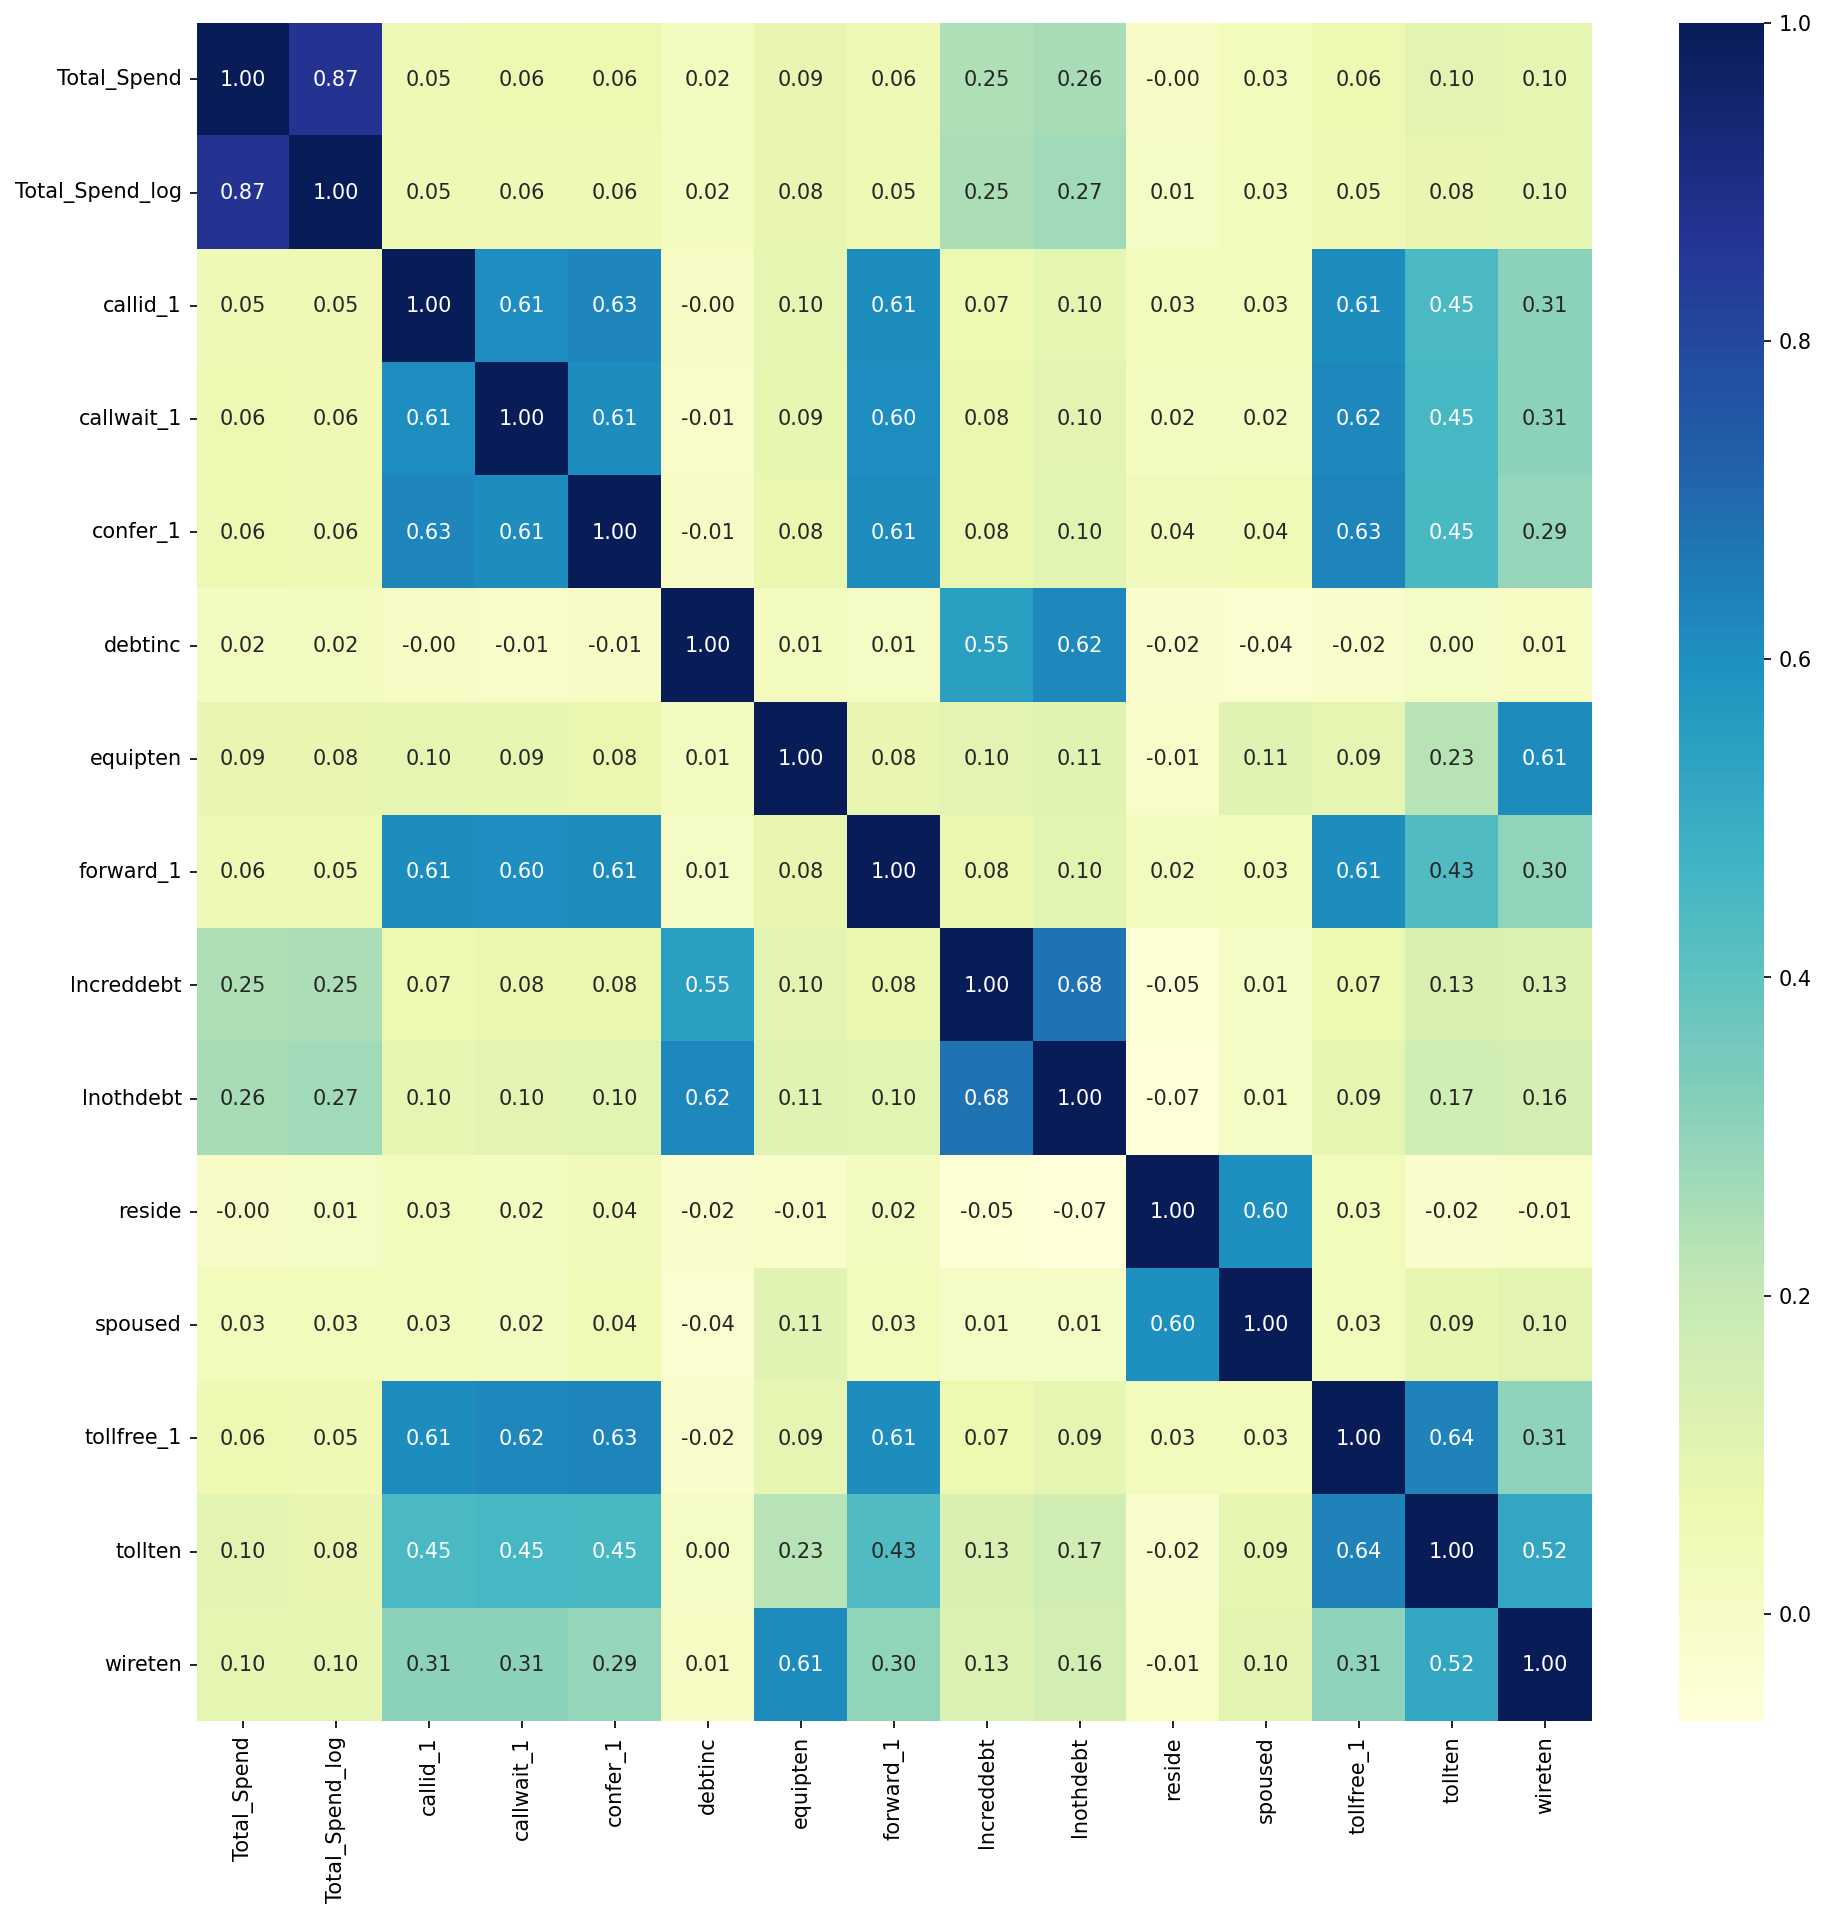

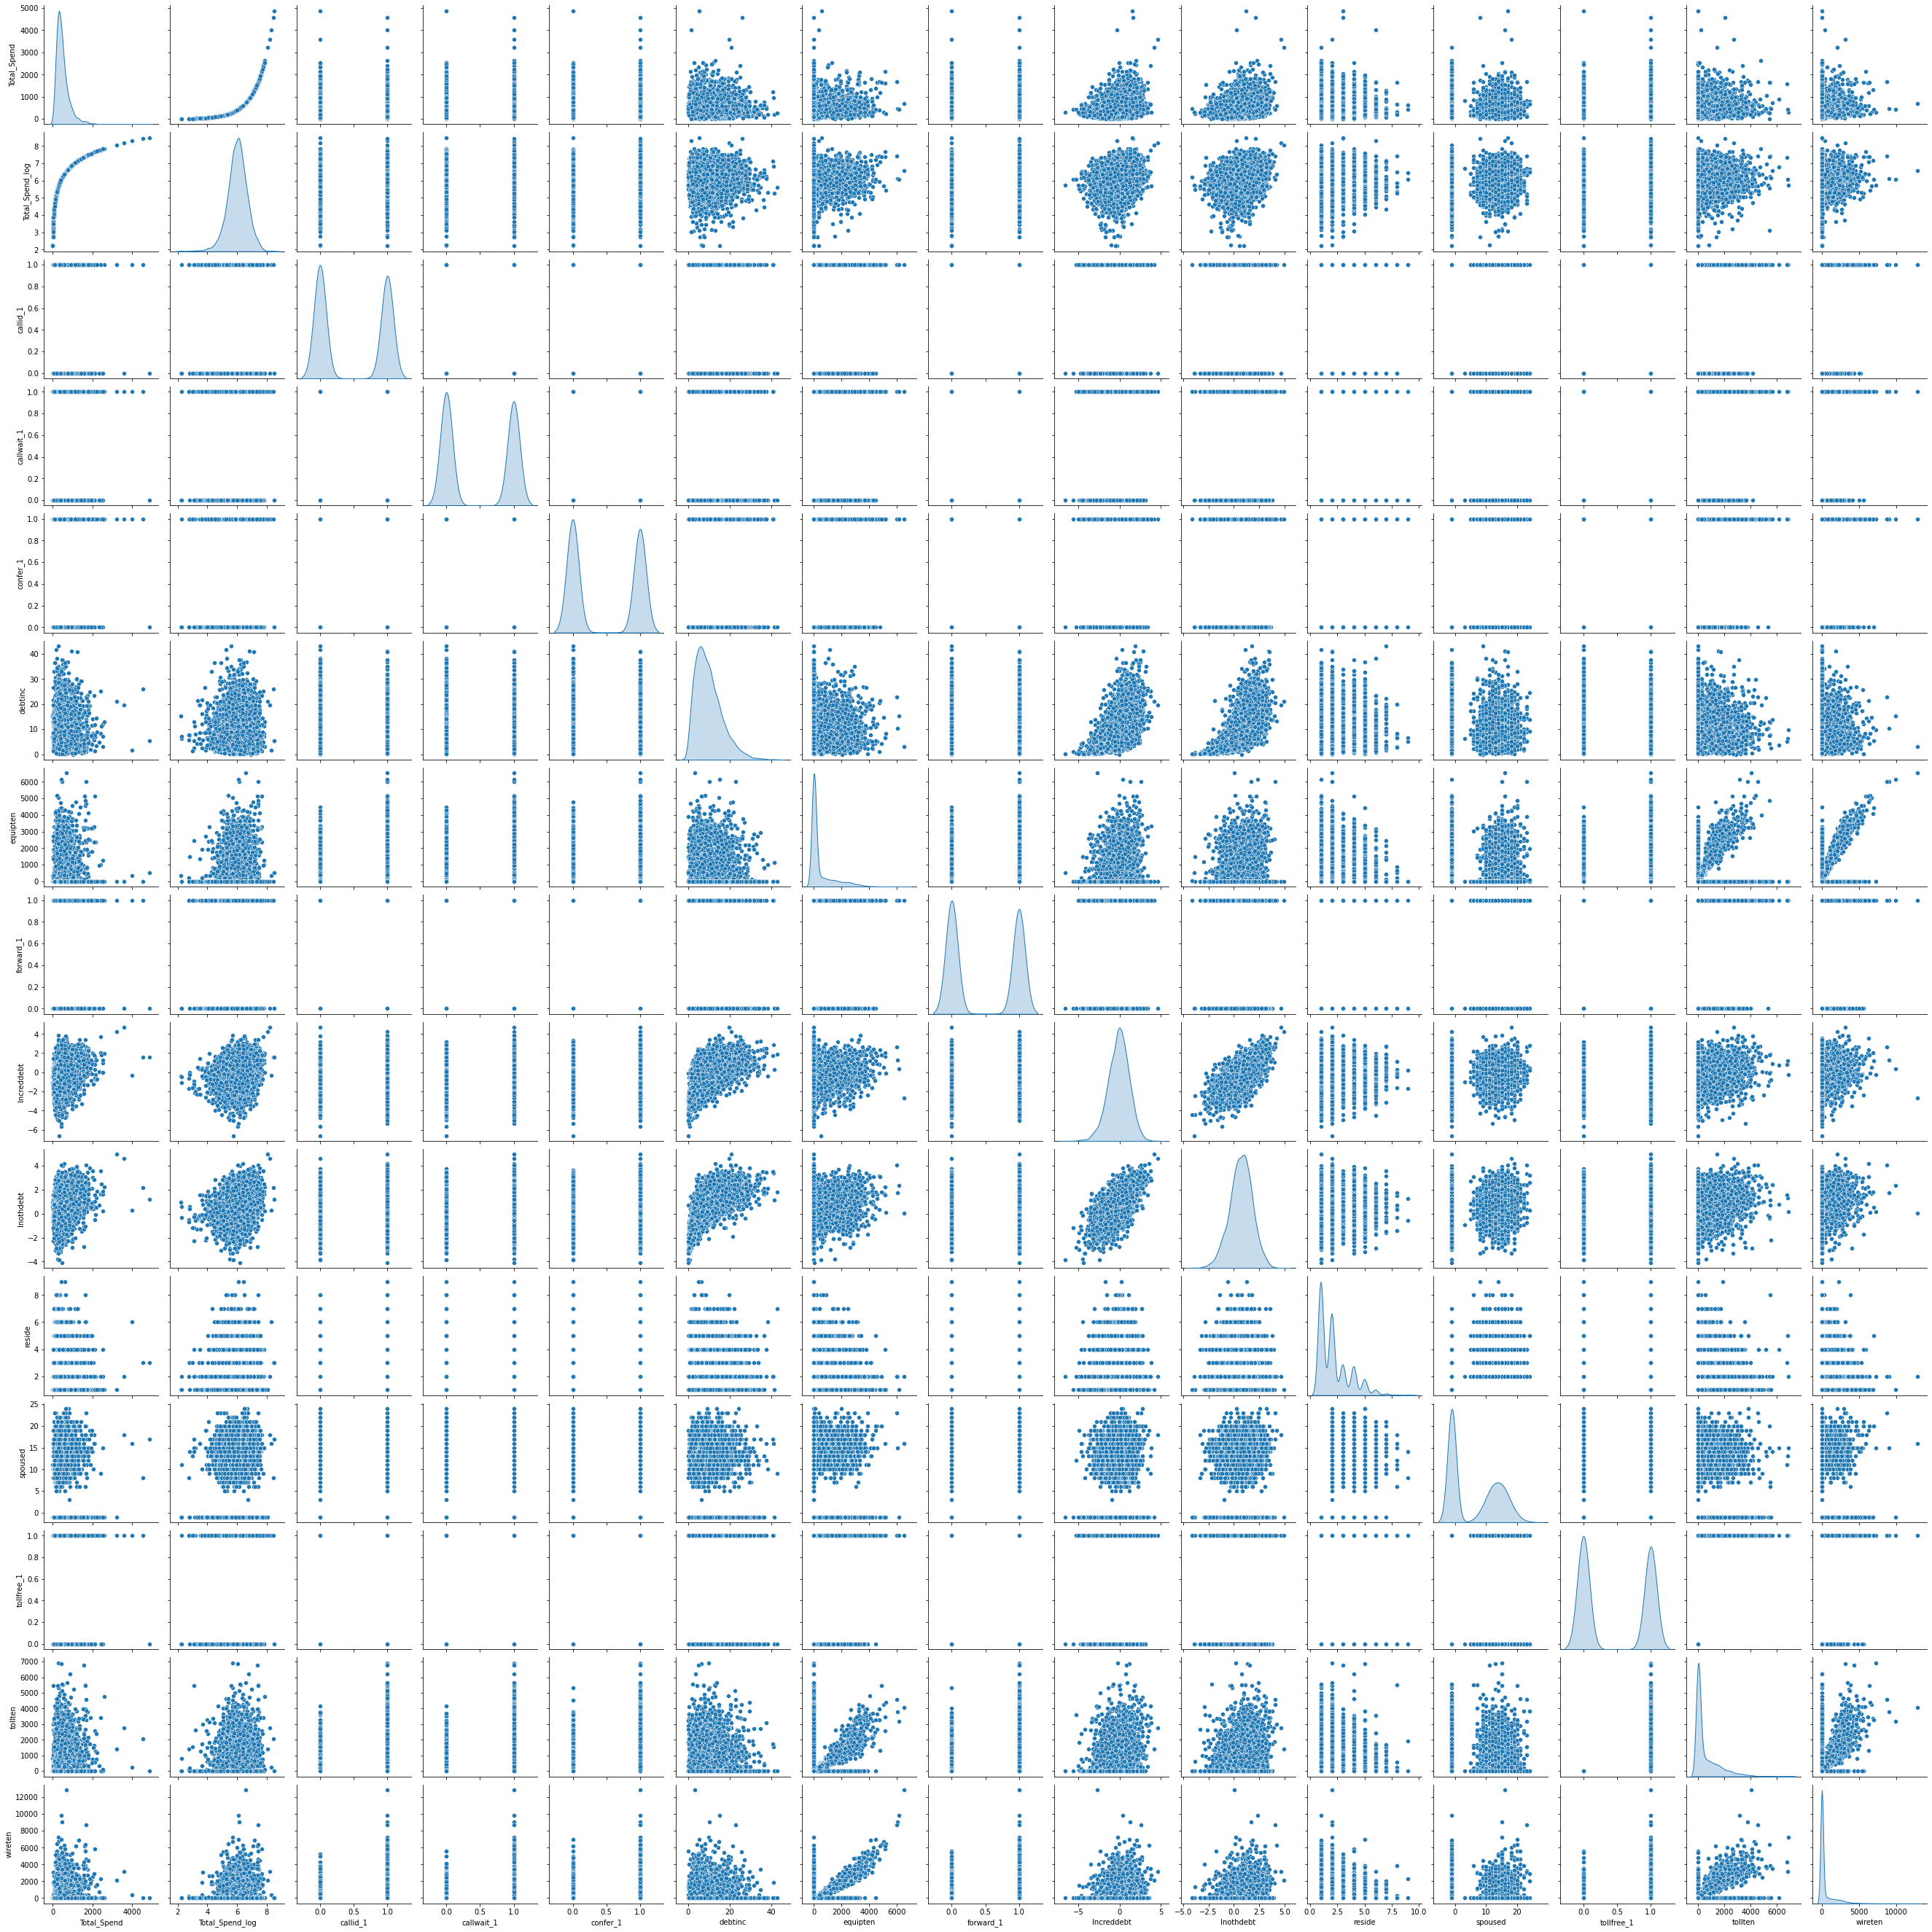

In [33]:
# Recursively running this cell, removing the unfavourable features and observing it's affect on the model
drop_cols = ['card2tenure', 'longmon', 'longten', 'tenure', 'lnlongten', 'income', 'pets_freshfish', 'tollmon', 'wiremon',
            'cardmon', 'carvalue', 'equipmon', 'cardtenure', 'othdebt', 'creddebt', 'carown_0', 'wireless_1', 'age', 'equip_1',
            'hometype_2', 'lninc', 'cardten']

cols = data_new.columns.difference(drop_cols)
trimmed_corr(data_new[cols], 0.6)

### Training and Testing Dataset 

In [35]:
# This cell has recursively been tweeked to assemble the most effective list of features to be elliminated by trying out different 
# combinations and their effects on the model, gathering some statistical information from the tests perforformed in the
# following cells

drop_cols = ['card2tenure', 'longmon', 'longten', 'tenure', 'lnlongten', 'income', 'pets_freshfish', 'tollmon', 'wiremon',
            'cardmon', 'carvalue', 'equipmon', 'cardtenure', 'othdebt', 'creddebt', 'carown_0', 'wireless_1', 'age', 'equip_1',
            'hometype_2', 'lninc', 'cardten', 'news_1', 'addresscat_5', 'jobcat_5', 'card2fee_1', 'jobsat_2', 'wireten', 
            'ownfax_1', 'jobsat_4', 'callwait_1', 'reason_3', 'pets_dogs', 'internet_2', 'callcard_1', 'region_3', 'jobcat_2', 
            'pets_small', 'homeown_1', 'addresscat_3', 'hometype_3', 'spoused', 'pets_birds', 'pets_cats', 'ed', 'callid_1', 
            'addresscat_3', 'hometype_3', 'spoused', 'pets_birds', 'pets_cats', 'ownpda_1', 'internet_1', 'jobcat_3', 'ownpc_1', 
            'tollten', 'hometype_4', 'region_2', 'vote_1', 'reside', 'region_4', 'reason_4', 'ownipod_1', 'commutebike_1', 
            'commutetime', 'multline_1', 'jobsat_3', 'addresscat_2', 'owncd_1', 'addresscat_4', 'region_5', 'jobcat_6', 
            'tollfree_1', 'pets_reptiles', 'confer_1', 'forward_1', 'jobsat_5', 'owntv_1', 'pets', 'pager_1', 'lnlongmon', 
            'pets_saltfish', 'equipten', 'voice_1', 'response_03_1', 'jobcat_4']

In [36]:
# For OLS

ols_cols = data_new.columns.difference(drop_cols)
ols_cols = ols_cols.difference(['Total_Spend'])

train, test=train_test_split(data_new,test_size=0.3,random_state=1)

ols_cols_join = " + ".join(ols_cols.difference(['Total_Spend_log']))
ols_formula = 'Total_Spend_log ~ ' + ols_cols_join
print('{} features\n'.format(len(ols_cols)))
print(ols_formula)

23 features

Total_Spend_log ~ card2_2 + card2_3 + card2_4 + card2_5 + card_2 + card_3 + card_4 + card_5 + carown_1 + debtinc + employ + gender_1 + hourstv + internet_3 + internet_4 + lncreddebt + lnothdebt + owndvd_1 + ownvcr_1 + reason_2 + reason_9 + retire_1


In [37]:
lm = smf.ols(ols_formula, train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        Total_Spend_log   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     77.76
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          9.02e-282
Time:                        18:06:08   Log-Likelihood:                -2904.3
No. Observations:                3500   AIC:                             5855.
Df Residuals:                    3477   BIC:                             5996.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6039      0.074     89.447      0.0

In [38]:
print(list(lm.pvalues[lm.pvalues > 0.05].sort_values(ascending=False).index))

['internet_3']


In [39]:
lm.pvalues.sort_values(ascending=False)

internet_3     8.889731e-02
hourstv        3.909314e-02
owndvd_1       3.830642e-02
internet_4     2.050847e-02
carown_1       1.787910e-02
ownvcr_1       5.680533e-03
employ         1.307906e-03
reason_9       4.164924e-04
gender_1       2.982793e-04
retire_1       1.650561e-06
lncreddebt     1.012086e-12
card2_5        8.175637e-14
reason_2       2.894139e-16
card_5         9.205799e-19
lnothdebt      4.883183e-20
debtinc        2.697875e-21
card2_3        7.437672e-40
card2_2        4.595082e-43
card2_4        7.147967e-44
card_2         2.742660e-76
card_3         1.417017e-87
card_4        2.388161e-106
Intercept      0.000000e+00
dtype: float64

In [40]:
# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices(ols_formula, train, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.round(1).sort_values(by = 'VIF Factor', ascending=False)

,Features,VIF Factor
0,Intercept,61.6
17,lnothdebt,2.9
10,debtinc,2.3
3,card2_4,2.3
7,card_4,2.3
2,card2_3,2.2
16,lncreddebt,2.1
1,card2_2,2.1
22,retire_1,2.1
6,card_3,2.0


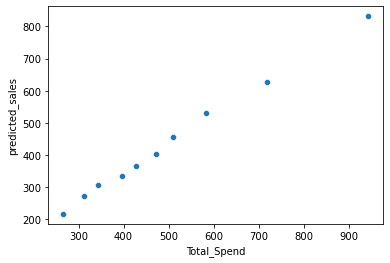

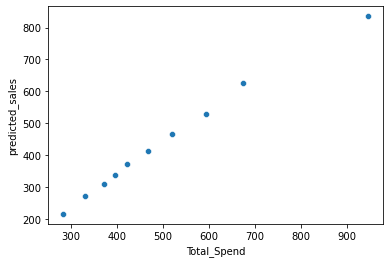

In [42]:

train['predicted_sales'] = np.exp(lm.predict(train))
test['predicted_sales'] = np.exp(lm.predict(test))

# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['predicted_sales'], 10, labels = False)
test['Deciles'] = pd.qcut(test['predicted_sales'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'predicted_sales']].groupby(train.Deciles).mean().sort_index(ascending = True)['predicted_sales']
Actual_avg = train[['Deciles', 'Total_Spend']].groupby(train.Deciles).mean().sort_index(ascending = True)['Total_Spend']
OLS_Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'predicted_sales']].groupby(test.Deciles).mean().sort_index(ascending = True)['predicted_sales']
Actual_avg = test[['Deciles', 'Total_Spend']].groupby(test.Deciles).mean().sort_index(ascending = True)['Total_Spend']
OLS_Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

sns.scatterplot(data = OLS_Decile_analysis_train, x='Total_Spend', y='predicted_sales')
plt.show()

sns.scatterplot(data = OLS_Decile_analysis_test, x='Total_Spend', y='predicted_sales')
plt.show()

In [43]:
OLS_Decile_analysis_train

,Deciles,predicted_sales,Total_Spend
0,0,216.994158,266.578171
1,1,273.539771,312.621486
2,2,306.818353,342.652543
3,3,335.927326,397.316486
4,4,365.839936,428.143914
5,5,404.733235,471.160686
6,6,457.104118,510.297371
7,7,531.343222,582.728057
8,8,628.587961,718.378886
9,9,831.475764,941.736514


In [44]:
OLS_Decile_analysis_test

,Deciles,predicted_sales,Total_Spend
0,0,216.093639,283.818333
1,1,272.742507,331.513800
2,2,309.220061,372.009800
3,3,338.044224,396.391600
4,4,372.888241,421.647867
5,5,413.160672,467.505867
6,6,465.822635,519.318933
7,7,529.732947,592.521600
8,8,626.622103,672.884267
9,9,835.096494,944.576000


## The model stands the test of decile analysis 👏

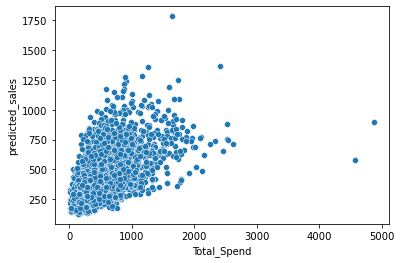

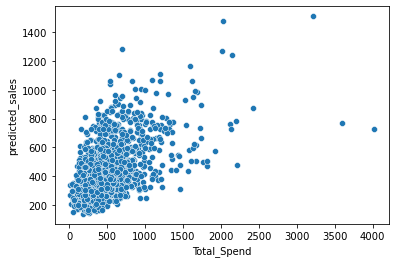

In [45]:
# Corelation between actual and predicted

sns.scatterplot(data = train, x='Total_Spend', y='predicted_sales')
plt.show()

sns.scatterplot(data = test, x='Total_Spend', y='predicted_sales')
plt.show()

In [46]:
# Writing output data into excel
output = pd.ExcelWriter('CreditCardSpend_output.xlsx')

# write the data into the file
OLS_Decile_analysis_train.to_excel(output, 'Decile', startrow=2 , startcol=0, index = False)
OLS_Decile_analysis_test.to_excel(output, 'Decile', startrow=2 , startcol=5, index = False)

# Machine learning

In [47]:
# Getting final features
X_cols = list(ols_cols.difference(['Total_Spend_log']))
print(X_cols)
X = data_new[X_cols]
Y = data_new['Total_Spend_log']

['card2_2', 'card2_3', 'card2_4', 'card2_5', 'card_2', 'card_3', 'card_4', 'card_5', 'carown_1', 'debtinc', 'employ', 'gender_1', 'hourstv', 'internet_3', 'internet_4', 'lncreddebt', 'lnothdebt', 'owndvd_1', 'ownvcr_1', 'reason_2', 'reason_9', 'retire_1']


In [48]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [54]:
# Different models
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('SupportVectorRegressor', SVR()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('XGBRFRegressor', XGBRegressor()))

In [60]:
# evaluate each model in turn
Model = []
mae=[]
rmse=[]
r2=[]
mape=[]


for name, model in models:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    scores=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error']
    cv_results = cross_validate(model, train_x, train_y, cv=kfold, n_jobs=-1, scoring=scores) 
    Model.append(name)
    mae.append(cv_results['test_neg_mean_absolute_error'].mean())
    rmse.append(cv_results['test_neg_root_mean_squared_error'].mean())
    r2.append(cv_results['test_r2'].mean())
    mape.append(cv_results['test_neg_mean_absolute_percentage_error'].mean())
    
results=pd.DataFrame({'MAE':mae, 'RMSE':rmse, 'r2':r2, 'MAPE':mape}, index=Model)
results

,MAE,RMSE,r2,MAPE
LinearRegression,-0.425847,-0.555842,0.317022,-0.075129
SupportVectorRegressor,-0.448408,-0.595604,0.216251,-0.079684
RandomForestRegressor,-0.455823,-0.597641,0.210962,-0.080227
GradientBoostingRegressor,-0.431043,-0.565154,0.294362,-0.076096
XGBRFRegressor,-0.476898,-0.613637,0.167883,-0.083674


## Linear Regression takes the cake 🍰 besides not the most satisfying performance

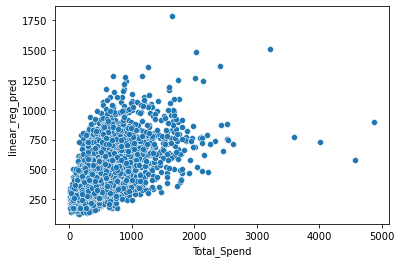

In [68]:
# Making Final Prediction using Linear Regression
ols_cols = data_new.columns.difference(drop_cols)
pre_df = data_new[ols_cols]
pre_df.loc[:,'linear_reg_pred'] = np.exp(lm.predict(pre_df))

sns.scatterplot(data = pre_df, x='Total_Spend', y='linear_reg_pred')
plt.show()

In [69]:
# Saving to excel
pre_df.to_excel(output, 'Predicted Total Spent', index = False)

output.save()